The dataset can be downloaded [here](https://drive.google.com/file/d/1yCe4uyIWUq_cJ9eoFK__KdtoRubrZtx5/view?usp=sharing)

The dataset was retrieved from [kaggle](https://www.kaggle.com/c/fake-news/data)


In [1]:
import itertools
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, RepeatedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, auc

In [2]:
# Import dataset in a dataframe
# Pandas.read_csv reads a comma-separated values (csv) file into dataframe and returns a two-dimensional data structure with labeled axes.
dataframe = pd.read_csv(r'C:\Users\dimde\Documents\University of Piraeus - MSc in Artificial Intelligence\Courses\First semester\Machine learning\Assignments\Machine learning\Fake news\Dataset\train.csv')

Reads a comma-separated values (csv) file into Dataframe and returns a two-dimensional data structure with labeled axes.

In [3]:
# Get dataframe information
# Represents the dimensionality of the dataframe
print('Dataframe shape: ', dataframe.shape, '\n')
# Represents the axes of the dataframe
print('Dataframe axes: ', dataframe.axes, '\n')
# Returns the dtypes in the dataframe
print('Dataframe dtypes: ', dataframe.dtypes, '\n')
# Returns an int representing the number of elements in the dataframe
print('Dataframe size: ', dataframe.size, '\n')
# Returns the first 10 rows of the dataframe
print('Dataframe head: ', '\n', dataframe.head(10), '\n')

Dataframe shape:  (20800, 5) 

Dataframe axes:  [RangeIndex(start=0, stop=20800, step=1), Index(['id', 'title', 'author', 'text', 'label'], dtype='object')] 

Dataframe dtypes:  id         int64
title     object
author    object
text      object
label      int64
dtype: object 

Dataframe size:  104000 

Dataframe head:  
    id                                              title  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2   2                  Why the Truth Might Get You Fired   
3   3  15 Civilians Killed In Single US Airstrike Hav...   
4   4  Iranian woman jailed for fictional unpublished...   
5   5  Jackie Mason: Hollywood Would Love Trump if He...   
6   6  Life: Life Of Luxury: Elton John’s 6 Favorite ...   
7   7  Benoît Hamon Wins French Socialist Party’s Pre...   
8   8  Excerpts From a Draft Script for Donald Trump’...   
9   9  A Back-Channel Plan for Ukraine and Russia, Co...   

               

Above we retrieve some information of the dataframe.

Firstly, we retrieve the dimensionality of the dataframe. Our dataset has 5 features and 20800 samples.

Then, we get the features of the dataframe. The 5 features are 'id', 'title', 'author', 'text' and 'label'.

Additionally, we extract the dataframe feature sample types (object).

Furthermore, we retrieve the dataframe size. This is the number of elements in the dataframe.

Last but not least, with dataframe.head we view the first 10 rows of the dataframe for analyzation.

Feature description:

* **id**: indicates the index of the article (from 0 to 20799, in total 20800 feature vectors/samples).

* **title**: indicates the title of the article.

* **author**: indicates the author of the article.

* **text**: indicates the actual main body of the article.

* **label**: indicates if the article is fake or not. Value is 0 if the article represents real information and value is 1 if the article represents fake information.

The features that are going to be examined are the features **label** and **text**.

In [4]:
# Convert the 0, 1 labels to 'REAL' and 'FAKE' for simplicity
# With Dataframe.loc set value for an entire column
dataframe.loc[(dataframe['label'] == 1) , ['label']] = 'FAKE'
dataframe.loc[(dataframe['label'] == 0) , ['label']] = 'REAL'

For our better visualization convert feature label values "0" to "REAL" and "1" to "FAKE". This is only done for comprehension.

In [5]:
# Visualize the head again to check the label changes
print('Converted dataframe head: ', '\n', dataframe.head(10), '\n')

Converted dataframe head:  
    id                                              title  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2   2                  Why the Truth Might Get You Fired   
3   3  15 Civilians Killed In Single US Airstrike Hav...   
4   4  Iranian woman jailed for fictional unpublished...   
5   5  Jackie Mason: Hollywood Would Love Trump if He...   
6   6  Life: Life Of Luxury: Elton John’s 6 Favorite ...   
7   7  Benoît Hamon Wins French Socialist Party’s Pre...   
8   8  Excerpts From a Draft Script for Donald Trump’...   
9   9  A Back-Channel Plan for Ukraine and Russia, Co...   

                         author  \
0                 Darrell Lucus   
1               Daniel J. Flynn   
2            Consortiumnews.com   
3               Jessica Purkiss   
4                Howard Portnoy   
5               Daniel Nussbaum   
6                           NaN   
7               Alissa J. Rubi

Now the feature label presents the 0 values with "REAL" and the 1 values with "FAKE".

In [6]:
# Isolate the text and label feature columns from the rest of the dataframe
labels = dataframe.label
labels.head()
print(labels.head)
text = dataframe.text
text.head()
print(text.head)

<bound method NDFrame.head of 0        FAKE
1        REAL
2        FAKE
3        FAKE
4        FAKE
         ... 
20795    REAL
20796    REAL
20797    REAL
20798    FAKE
20799    FAKE
Name: label, Length: 20800, dtype: object>
<bound method NDFrame.head of 0        House Dem Aide: We Didn’t Even See Comey’s Let...
1        Ever get the feeling your life circles the rou...
2        Why the Truth Might Get You Fired October 29, ...
3        Videos 15 Civilians Killed In Single US Airstr...
4        Print \nAn Iranian woman has been sentenced to...
                               ...                        
20795    Rapper T. I. unloaded on black celebrities who...
20796    When the Green Bay Packers lost to the Washing...
20797    The Macy’s of today grew from the union of sev...
20798    NATO, Russia To Hold Parallel Exercises In Bal...
20799      David Swanson is an author, activist, journa...
Name: text, Length: 20800, dtype: object>


Isolate the text and label from the dataframe so that we use it for classification.

In [7]:
# Custom stop words list
stop_words_list = ['a, the, of, this, that', 'him', 'well', 'if', 'until']

# Initialize a TfidfVectorizer
# Tested for many different case scenarios
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_df = 0.7, max_features = 1000)

## Bag-of-words model
The **bag-of-words** model is a method of representing text data when modeling text with machine learning algorithms. It is easy to comprehend and implement and has seen huge success in applications such as language modeling and document classification.

An issue with modeling text is that it is disorganized, and methods like machine learning algorithms fancy defined fixed-length inputs and outputs. Since machine learning algorithms cannot operate with text directly, the text must be changed into vectors of numbers. Therefore we do feature encoding with the bag-of-words model of text. It is a well liked and plain method of feature encoding with text.

The method is simple and adaptable and can be used in a lot of ways for pulling out features from documents. A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:
* A vocabulary of known words.
* A measure of the presence of known words.

The order of occurrence is not important. We only care about whether known words occur in the document. The bag-of-words approach, looks at the histogram of the words within the text.

The objective is to transform each document of free text into a vector that we can use as input or output for a machine learning model. The simplest scoring method is to mark the presence of words as 0 for absent, and 1 for present. New documents that overlap with the vocabulary of known words, but may include words outside of the vocabulary, can still be encoded, where only the occurrence of known words are scored and unknown words are ignored.

In this assignment each article is a "document" and all of the articles together are the entire corpus of "documents". An entire corpus of documents can thus be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.

For a very large corpus, such as thousands of books, the length of the vector might be thousands or millions of positions. Furthermore, each document may include very few of the known words in the vocabulary. This results in a vector with lots of zero scores, called a sparse vector or sparse representation. Sparse vectors require more memory and computational resources when modeling and the vast number of positions or dimensions can make the modeling process very challenging for traditional algorithms. Therefore, there is need to decrease the size of the vocabulary when using a bag-of-words model.

There are some techniques that can be used as a first step to reduce the size of the vocabulary. For example:
* ignoring uppercase and lowercase in words.
* ignoring punctuation.
* ignoring frequent words that don’t contain much information (called stop words) like "a", "of", "him", "the".
* fixing misspelled words.
* reducing words to their stem using stemming algorithms (for example "use" from "using").

A more sophisticated approach is to create a vocabulary of grouped words. This changes the scope of the vocabulary and also allows the bag-of-words to capture somewhat more meaning from the document. By doing this, each word or token is called a **gram**. Creating a vocabulary of two-word pairs is called a **2-gram model** or a **bigram model**. As a result, only the bigrams that appear in the corpus are modeled, not all possible bigrams. A **3-gram model** or a **trigram** is a three-word sequence of words. The general approach is called the **n-gram model**, where n refers to the number of grouped words. Often a simple bigram approach is better than a 1-gram bag-of-words model for tasks like documentation classification.

Once a vocabulary method has been chosen, the occurrence of words in the documents needs to be scored. As mentioned earlier, the simplest scoring method is **binary scoring** which marks the presence of words as 0 for absent, and 1 for present. Another scoring method is **counts**, which counts the number of times each word appears in a document. Additionally, **frequencies** scoring method calculates the frequency that each word appears in a document out of all the words in the document.

Feature hashing is when known words use a hash representation in the vocabulary. This addresses the problem of having a very large vocabulary for a large text corpus because then the size of the hash space can be defined, which is in turn the size of the vector representation of the document. Words are hashed deterministically to the same integer index in the target hash space. A binary score or count can then be used to score the word. The challenge is to choose a hash space to accommodate the chosen vocabulary size to minimize the probability of collisions and trade-off sparsity.

## TF-IDF
A problem with scoring word frequency is that highly frequent words start to dominate in the document (for example, larger score), but may not contain as much "information" to the model as more rare but perhaps domain specific words.

One approach is to rescale the frequency of words by how often they appear in entire corpus of documents, so that the scores for frequent words like "the" that are also frequent across all documents are penalized. This approach to scoring is called "Term Frequency–Inverse Document Frequency", or TF-IDF for short, where:
* Term Frequency is a scoring of the frequency of the word in the current document.
* Inverse Document Frequency is a scoring of how rare the word is across documents.

The scores are a weighting where not all words are equally as important or interesting. The scores have the effect of highlighting words that are distinct (contain useful information) in a given document. Thus, the IDF of a rare term is high, whereas the IDF of a frequent term is likely to be low.

The bag-of-words model is very simple to understand and implement and offers a lot of flexibility for customization on specific text data. It has been used with great success on prediction problems like language modeling and documentation classification. Nevertheless, it suffers from some drawbacks, such as:
* Vocabulary: The vocabulary requires careful design, most specifically in order to manage the size, which impacts the sparsity of the document representations.
* Sparsity: Sparse representations are harder to model both for computational reasons (space and time complexity) and also for information reasons, where the challenge is for the models to harness so little information in such a large representational space.
* Meaning: Discarding word order ignores the context, and in turn meaning of words in the document (semantics). Context and meaning can offer a lot to the model, that if modeled could tell the difference between the same words differently arranged (“this is interesting” as opposed to “is this interesting”), synonyms (“old bike” vs “used bike”), and many more semantics.


In [8]:
# Fit the text feature set to TfidfVectorizer
tfidf = tfidf_vectorizer.fit_transform(text.values.astype('str'))

# View vocabulary length (features)
vocabulary_len = len(tfidf_vectorizer.get_feature_names())
print('TfidfVectorizer number of features: ', vocabulary_len, '\n')

# Visualize the stop words used by TfidfVectorizer
stop_words_len = tfidf_vectorizer.get_stop_words()
print('TfidfVectorizer stop words: ', '\n', stop_words_len, '\n')

TfidfVectorizer number of features:  1000 

TfidfVectorizer stop words:  
 frozenset({'hereupon', 'them', 'as', 'name', 'seemed', 'ours', 'here', 'my', 'i', 'wherein', 'inc', 'last', 'themselves', 'beyond', 'together', 'next', 'only', 'therefore', 'co', 'no', 'else', 'latter', 'but', 'system', 'never', 'others', 'after', 'on', 'indeed', 'former', 'to', 'some', 'one', 'towards', 'ie', 'until', 'each', 'top', 'namely', 'afterwards', 'are', 'there', 'part', 'what', 'thereafter', 'am', 'anyway', 'mine', 'everyone', 'front', 'yourself', 'well', 'forty', 'then', 'can', 'being', 'nine', 'every', 'the', 'before', 'everything', 'may', 'beforehand', 'since', 'he', 'is', 'why', 'whither', 're', 'had', 'least', 'have', 'anyone', 'when', 'thereby', 'side', 'these', 'became', 'without', 'first', 'always', 'most', 'cannot', 'interest', 'however', 'into', 'same', 'though', 'those', 'ten', 'yours', 'also', 'behind', 'toward', 'around', 'amongst', 'hereby', 'more', 'twenty', 'ever', 'us', 'eight', 'keep

Fit the text feature set on the TfidfVectorizer. The text is converted to vectors of numbers and now can be used by classifiers for prediction.

Get the tfidfvectorizer features and visualize the stop words.

In [9]:
# Split the dataset with train_test_split
#x_train,x_test,y_train,y_test = train_test_split(tfidf, labels, test_size = 0.2, random_state = 7)

# Split the data and cross validate with RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=0)
for i_train, i_test in rkf.split(tfidf, labels):
    x_train = tfidf[i_train, :]
    y_train = labels[i_train]
    x_test = tfidf[i_test, :]
    y_test = labels[i_test]

Initially, train_test_split was used for spliting the dataset and allocating the train and test set percentages. But we can't know for sure that the split that is done by train_test_split is unbiased. What if one of the subsets of data has only articles written by a specific author? This would result in overfitting.

To avoid this RepeatedKFold was used to split the data into spits of 5. This way we are more confident than before that the results will be unbiased.

In [10]:
# Initialize the LogisticRegression classifier and fit training sets
lr_classifier = LogisticRegression()
lr_classifier.fit(x_train, y_train)
# Get probability estimates for the x_test
cl_probs = lr_classifier.predict_proba(x_test)
cl_probs = cl_probs[:, 1]
# Predict with Logistic Regression classifier
y_pred = lr_classifier.predict(x_test)

Fit the data and predict with the logistic regression classifier.

Extract the probability estimate for label 'FAKE' to use it for the ROC curve.

Accuracy:  93.79807692307692 % 

Confusion matrix: 
 [[1965  111]
 [ 147 1937]] 

Precision:  0.94580078125 

Recall:  0.9294625719769674 

Specificity:  0.9465317919075145 

False positive rate:  0.053468208092485536 

F1-score:  0.9375605033881897 

Random: ROC AUC = 0.5
Classifier: ROC AUC = 0.9851467183680414


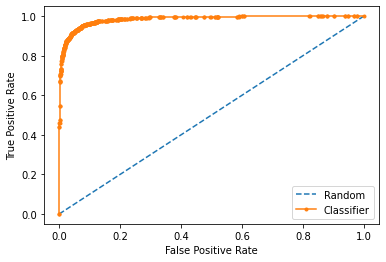

Classifier: auc=  0.9859841692998391


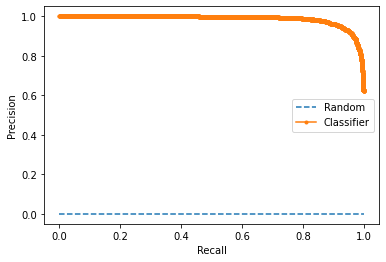

In [11]:
# Metrics
# Calculate accuracy: (tp + tn) / (tp + tn + fp + fn)
# Accuracy = Number of correct predictions / Total number of predictions
Accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', Accuracy * 100,'%', '\n')

# Calculate confusion matrix table
#           Actual class
# Predicted [TP, FP]
# class     [FN, TN]
Conf_matrix = confusion_matrix(y_test, y_pred, labels = ['FAKE', 'REAL'])
# Extract true negatives, false positives, false negatives and true positives from confusion matrix to calculate ROC curve
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Confusion matrix: ' '\n', Conf_matrix, '\n')

# Calculate precision: tp / (tp + fp)
precision = tp / (tp + fp)
print('Precision: ', precision, '\n')

# Calculate recall: tp / (tp + fn)
# True positive rate / Sensitivity
recall = tp / (tp + fn)
print('Recall: ', recall, '\n')

# Calculate specificity: Tn / (Tn + Fp)
specificity = tn / (tn + fp)
print('Specificity: ', specificity, '\n')

#Calculate False positive rate
False_positive_rate = 1 - specificity
print('False positive rate: ', False_positive_rate, '\n')

# Calculate F1-score
# F1 score is a weighted balance between precision and recall
f1_score = 2 * (precision * recall) / (precision + recall)
print('F1-score: ', f1_score, '\n')

# Calculate the ROC curve
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
cl_auc = roc_auc_score(y_test, cl_probs)
print('Random: ROC AUC =', ns_auc)
print('Classifier: ROC AUC =', cl_auc)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label = 'REAL')
cl_fpr, cl_tpr, _ = roc_curve(y_test, cl_probs, pos_label = 'REAL')
# Plot the ROC curve
pyplot.plot(ns_fpr, ns_tpr, linestyle = '--', label = 'Random')
pyplot.plot(cl_fpr, cl_tpr, marker = '.', label = 'Classifier')
# Name axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# Show the legend
pyplot.legend()
# Show the plot
pyplot.show()

# Calculate the precision-recall curve
cl_precision, cl_recall, _ = precision_recall_curve(y_test, cl_probs, pos_label = 'REAL')
cl_auc = auc(cl_recall, cl_precision)
print('Classifier: auc= ', cl_auc)
# Plot the precision-recall curves
random = len(y_test[y_test == 1]) / len(y_test)
pyplot.plot([0, 1], [random, random], linestyle='--', label = 'Random')
pyplot.plot(cl_recall, cl_precision, marker='.', label = 'Classifier')
# Name axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# Show the legend
pyplot.legend()
# Show the plot
pyplot.show()

Metrics and results for logistic regression.

In [12]:
# Initialize the Multinomial Naive Bayes classifier and fit training sets
multinomialnb_classifier = MultinomialNB()
multinomialnb_classifier.fit(x_train, y_train)
# Get probability estimates for the x_test
cl_probs = multinomialnb_classifier.predict_proba(x_test)
cl_probs = cl_probs[:, 1]
# Predict with Multinomial Naive Bayes classifier
y_pred = multinomialnb_classifier.predict(x_test)

Fit the data and predict with the Naive Bayes classifier.

Extract the probability estimate for label 'FAKE' to use it for the ROC curve.

Accuracy:  88.46153846153845 % 

Confusion matrix: 
 [[1802  274]
 [ 206 1878]] 

Precision:  0.8726765799256505 

Recall:  0.9011516314779271 

Specificity:  0.8680154142581888 

False positive rate:  0.13198458574181116 

F1-score:  0.8866855524079319 

Random: ROC AUC = 0.5
Classifier: ROC AUC = 0.9535029715346582


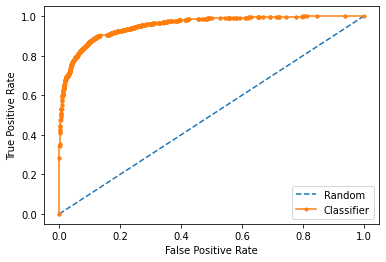

Classifier: auc=  0.9574183620961784


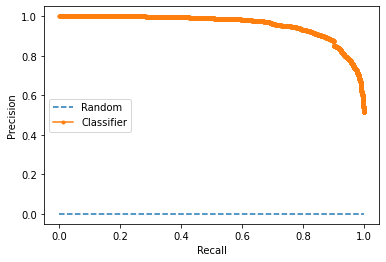

In [13]:
# Metrics
# Calculate accuracy: (tp + tn) / (tp + tn + fp + fn)
# Accuracy = Number of correct predictions / Total number of predictions
Accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', Accuracy * 100,'%', '\n')

# Calculate confusion matrix table
#           Actual class
# Predicted [TP, FP]
# class     [FN, TN]
Conf_matrix = confusion_matrix(y_test, y_pred, labels = ['FAKE', 'REAL'])
# Extract true negatives, false positives, false negatives and true positives from confusion matrix to calculate ROC curve
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Confusion matrix: ' '\n', Conf_matrix, '\n')

# Calculate precision: tp / (tp + fp)
precision = tp / (tp + fp)
print('Precision: ', precision, '\n')

# Calculate recall: tp / (tp + fn)
# True positive rate / Sensitivity
recall = tp / (tp + fn)
print('Recall: ', recall, '\n')

# Calculate specificity: Tn / (Tn + Fp)
specificity = tn / (tn + fp)
print('Specificity: ', specificity, '\n')

#Calculate False positive rate
False_positive_rate = 1 - specificity
print('False positive rate: ', False_positive_rate, '\n')

# Calculate F1-score
# F1 score is a weighted balance between precision and recall
f1_score = 2 * (precision * recall) / (precision + recall)
print('F1-score: ', f1_score, '\n')

# Calculate the ROC curve
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
cl_auc = roc_auc_score(y_test, cl_probs)
print('Random: ROC AUC =', ns_auc)
print('Classifier: ROC AUC =', cl_auc)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label = 'REAL')
cl_fpr, cl_tpr, _ = roc_curve(y_test, cl_probs, pos_label = 'REAL')
# Plot the ROC curve
pyplot.plot(ns_fpr, ns_tpr, linestyle = '--', label = 'Random')
pyplot.plot(cl_fpr, cl_tpr, marker = '.', label = 'Classifier')
# Name axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# Show the legend
pyplot.legend()
# Show the plot
pyplot.show()

# Calculate the precision-recall curve
cl_precision, cl_recall, _ = precision_recall_curve(y_test, cl_probs, pos_label = 'REAL')
cl_auc = auc(cl_recall, cl_precision)
print('Classifier: auc= ', cl_auc)
# Plot the precision-recall curves
random = len(y_test[y_test == 1]) / len(y_test)
pyplot.plot([0, 1], [random, random], linestyle='--', label = 'Random')
pyplot.plot(cl_recall, cl_precision, marker='.', label = 'Classifier')
# Name axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# Show the legend
pyplot.legend()
# Show the plot
pyplot.show()

Metrics and results for Naive Bayes.